# Notebook Iteracion final Modelado

### Objetivo: Crear el modelo final implementando validación cruzada e importancia de vbariables


In [116]:
# Funciones generales
import sys
sys.path.append('../')
# A medida que avanzan las iteraciones se crearan mas funcinoes transversales
from funciones import *

# Tuneo de hiperparámetros
from sklearn.model_selection import ParameterGrid

# Libreria para manejo de balance de datos
import smogn

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Serializacion
import pickle

# Grid Search Validacion cruzada
from sklearn.model_selection import GridSearchCV

# xgboost
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

**Lectura de datos**
Dada la estabilidad que muestra el resultado de la iteracion 2 sobre las variables predictoras, se utiliza la base resultante de esta

In [95]:
import os 
# get current directory
path = os.getcwd()
# parent directory
path = os.path.abspath('../')
data_model = pd.read_csv(path + "/iteracion_2/datos_iteracion_2.csv")
data_model.head()

,precio,zona,barrio_sector,baños_familiares,area_bruta,numero_niveles,parqueaderos,alcobas_familiares,estrato,area_total,...,closet_de_linos,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,dispositivos_automatizacion,alarma,tipo_cocina_freq,tipo_pisos_freq
0,1100000.0,centro,castilla,1.0,95.0,1.0,0.0,3.0,0.0,95.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
1,950000.0,centro,el salvador,1.0,70.0,1.0,0.0,2.0,3.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
2,970000.0,centro,los angeles,1.0,38.0,1.0,0.0,1.0,4.0,38.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
3,1400000.0,centro,prado,1.0,50.0,1.0,1.0,2.0,0.0,50.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
4,800000.0,centro,12 de octubre,1.0,92.0,1.0,0.0,3.0,2.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709


**Variables predictoras**

In [96]:
pred_columns = [
    'baños_familiares',
    'area_bruta', 
    'numero_niveles',
    'parqueaderos', 
    'alcobas_familiares', 
    'estrato', 
    'area_total',
    'juegos_infantiles', 
    'balcon', 
    'zona_ropas', 
    'camaras_cctv',
    'cancha_polideportiva', 
    'ascensor', 
    'cancha_squash', 
    'zona_bbq',
    'patio', 
    'unidad_cerrada_conjunto', 
    'zonas_verdes',
    'aire_acondicionado', 
    'jacuzzi', 
    'red_de_Gas', 
    'turco', 
    'porteria_24_7',
    'sauna', 
    'calentador_de_agua', 
    'terraza', 
    'closet_de_linos',
    'biblioteca', 
    'parqueadero_visitantes', 
    'gimnasio', 
    'piscina',
    'salon_social', 
    'dispositivos_automatizacion', 
    'alarma',
    'tipo_cocina_freq', 
    'tipo_pisos_freq'
]

**Variables predictoras**

En la iteración 2 el analisis de distribución y correlaciones dió como resultado la eliminación de las variables:

- columns_disc_corr
- numero_niveles
- zona_ropas
- camaras_cctv
- cancha_polideportiva
- cancha_squash
- zona_bbq
- patio
- aire_acondicionado
- jacuzzi
- red_de_Gas
- terraza
- dispositivos_automatizacion
- alarma
- area_total
- porteria_24_7

Se reutiliza estas variables, sin embargo por criterio del negocio se conservan las siguientes variables dejando su eliminación para un posterior analisis de importancia de variables:

- cancha_polideportiva


In [97]:
columns_disc_corr = [
    "numero_niveles",
    "zona_ropas",
    "camaras_cctv",
    "cancha_squash",
    "zona_bbq",
    "patio",
    "aire_acondicionado",
    "jacuzzi",
    "red_de_Gas",
    "terraza",
    "dispositivos_automatizacion",
    "alarma",
    "area_total",
    "porteria_24_7"
]

**Estandarización**

In [98]:
X = data_model[pred_columns]
Y = data_model['precio']

In [99]:
X_est = estandarizar(X)

**Clustering**

Se procede con la ejecucion del algoritmo de kmeans entre las variables __precio__ y __area_bruta__, esta última por ser la mas relevante en la ejecución del modelo línea base y el análisis de correlaciones

In [100]:
X_est['precio'] = Y.values

In [101]:
x_cluster = X_est[['precio', 'area_bruta']].values
for k in [2,3,4,5]:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans_labels = kmeans.fit_predict(x_cluster)
    sample_silhouette_values = silhouette_samples(x_cluster, kmeans_labels)
    print("silhouette_score k = {} : {}".format(k , sample_silhouette_values.mean()))

silhouette_score k = 2 : 0.5965131713561477
silhouette_score k = 3 : 0.6348158925476787
silhouette_score k = 4 : 0.6058642604255898
silhouette_score k = 5 : 0.5952737314776967


Segun el cálculo del coeficiente de siluetas se obtiene un mejor resultado para 3 clusters, se selecciona este valor para hacer la división de los datos

Entrenamiento y calculo de las etiquetas de los clusters

In [102]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans_labels = kmeans.fit_predict(x_cluster)

Se añade la etiqueta cluster como nueva variable de la base de entrenamiento

In [103]:
X_est['cluster'] = kmeans_labels

Los rangos de precios de cada cluster son:

In [104]:
print("Cluster 0: ", X_est[X_est['cluster']==0]['precio'].min(), X_est[X_est['cluster']==0]['precio'].max())
print("Cluster 1: ", X_est[X_est['cluster']==1]['precio'].min(), X_est[X_est['cluster']==1]['precio'].max())
print("Cluster 2: ", X_est[X_est['cluster']==2]['precio'].min(), X_est[X_est['cluster']==2]['precio'].max())

Cluster 0:  500000.0 2700000.0
Cluster 1:  2750000.0 5500000.0
Cluster 2:  5600000.0 9500000.0


Serialización del modelo clustering

In [105]:
with open('kmeans_arriendos.pkl', 'wb') as pickle_file:
    pickle.dump(kmeans, pickle_file) 

**Modelo**

La variacion de los hiperparámetros seleccionada corresponde al resultado de multiples ejecuciones observando los resultados obtenidos en los archivos csv que determinaron el aumento, disminución o eliminación de hiperparámetros

Se eliminan las variables de la base de modelado dado los anteriores análisis

In [106]:
x_model = X_est.drop(columns = columns_disc_corr)
x_model = x_model.drop(columns='precio')
y_model = X_est['precio']
imprimir_dimensiones(x_model)

Numero de muestras: 2892, Número de columnas: 23


**Dvisión de los datos:** Entrenamiento 80%, Test 20%

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x_model, y_model, test_size = 0.20, train_size = 0.80, random_state = 17)
print("Tamaño de los Datos de Entrenamiento = ", x_train.shape)
print("Tamaño de los Datos de Validación = ", x_test.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", y_train.shape)
print("Tamaño del Vector de Clases de Prueba = ", y_test.shape)

Tamaño de los Datos de Entrenamiento =  (2313, 23)
Tamaño de los Datos de Validación =  (579, 23)
Tamaño del Vector de Clases de Entrenamiento =  (2313,)
Tamaño del Vector de Clases de Prueba =  (579,)


**XGBOOST**

In [109]:
for column in x_train.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_train[column] = x_train[column].astype('float') 

for column in x_test.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_test[column] = x_test[column].astype('float') 

In [110]:
param_grid_xgb = {
    'n_estimators' : [80, 100],
    'max_depth' : [5, 7],
    'learning_rate' : [.03,.05],
    'objective' : ['reg:squarederror'],
    'subsample' : [0.5,0.8],
    'eta' : [.01,.05],
}

grid = GridSearchCV(
        estimator  = xgb.XGBRegressor(random_state=123),
        param_grid = param_grid_xgb,
        scoring    = 'r2',
        n_jobs     = - 1,
        cv         = 5, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=x_train, y= y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.05], 'learning_rate': [0.03, 0.05],
                         'max_depth': [5, 7], 'n_estimators': [80, 100],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.5, 0.8]},
             return_train_score=True, scoring='r2')

In [111]:
resultados_cv = pd.DataFrame(grid.cv_results_)
resultados_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_eta,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
27,0.05,0.05,5,100,reg:squarederror,0.8,0.921881,0.002719,0.954271,0.000375
11,0.01,0.05,5,100,reg:squarederror,0.8,0.921881,0.002719,0.954271,0.000375
10,0.01,0.05,5,100,reg:squarederror,0.5,0.921777,0.002787,0.952386,0.000712
26,0.05,0.05,5,100,reg:squarederror,0.5,0.921777,0.002787,0.952386,0.000712


In [112]:
grid.best_params_

{'eta': 0.01,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [113]:
xgb_final = grid.best_estimator_

In [114]:
resultados = {'R2_train': [],
               'R2_test': [],
               'RMSE_train': [],
               'RMSE_test': [],
               'MAPE_train': [],
               'MAPE_test': [],}
resultados['R2_train'].append(r2_score(y_true=y_train, y_pred=xgb_final.predict(x_train)))
resultados['R2_test'].append(r2_score(y_true=y_test, y_pred=xgb_final.predict(x_test)))
resultados['RMSE_train'].append(mean_squared_error(y_true=y_train, y_pred=xgb_final.predict(x_train), squared=False))
resultados['RMSE_test'].append(mean_squared_error(y_true=y_test, y_pred=xgb_final.predict(x_test), squared=False))
resultados['MAPE_train'].append(mean_absolute_percentage_error(y_true=y_train, y_pred  = xgb_final.predict(x_train)))
resultados['MAPE_test'].append(mean_absolute_percentage_error(y_true=y_test, y_pred  = xgb_final.predict(x_test)))
pd.DataFrame(resultados)

,R2_train,R2_test,RMSE_train,RMSE_test,MAPE_train,MAPE_test
0,0.951452,0.918886,453708.401942,599601.273484,0.121318,0.14595


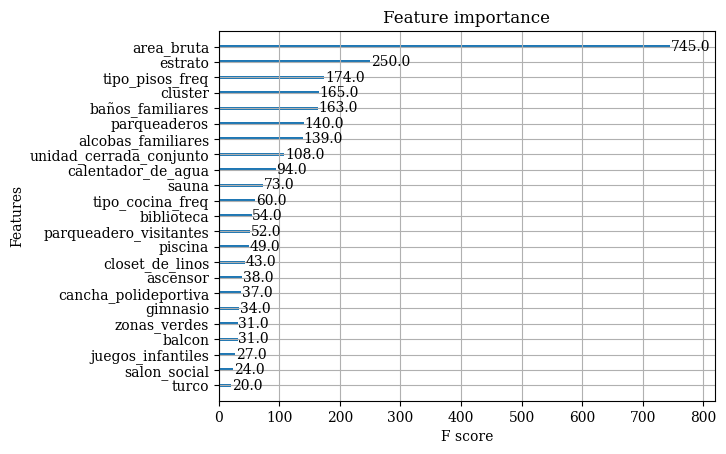

<Figure size 1600x1600 with 0 Axes>

In [115]:
xgb.plot_importance(xgb_final)
plt.figure(figsize = (16, 16))
plt.show()